# Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

https://www.kaggle.com/datasets/ghoshsaibal/creditcard

# Analiza

## Ucitavanje podataka

In [2]:
def csv_to_pd(path):
    return pd.read_csv(path)

def pandas_uniques(df, col_name):
    counts = df[col_name].value_counts()
    unique = df[col_name].unique()
    return unique,counts

def print_uniques(df, cols, count_per_categ=False):
    for c in cols:
        print()
        print(c)
        print("-----------------")
        u, b = pandas_uniques(df,c)
        print("\tVrednosti: ",u)
        print("\tBroj jedinstvenih: ",len(u))
    
        if not count_per_categ: continue
        print("\tJedinstvenih:")
        for i in range(len(b)):
            print("\t",b.iloc[i])

In [3]:
applications = csv_to_pd("./data/application_record.csv")
credits = csv_to_pd("./data/credit_record.csv")

In [4]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [5]:
cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',\
        'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']\

print_uniques(applications,cols)


CODE_GENDER
-----------------
	Vrednosti:  ['M' 'F']
	Broj jedinstvenih:  2

FLAG_OWN_CAR
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

FLAG_OWN_REALTY
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

NAME_INCOME_TYPE
-----------------
	Vrednosti:  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
	Broj jedinstvenih:  5

NAME_EDUCATION_TYPE
-----------------
	Vrednosti:  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
	Broj jedinstvenih:  5

NAME_FAMILY_STATUS
-----------------
	Vrednosti:  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
	Broj jedinstvenih:  5

NAME_HOUSING_TYPE
-----------------
	Vrednosti:  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
	Broj jedinstvenih:  6

OCCUPATION_TYPE
-----------------
	Vrednosti:  [nan 'Security staff' 'Sales staff' 'Accountants' '

In [6]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [7]:
cols = ['STATUS']
print_uniques(credits,cols)


STATUS
-----------------
	Vrednosti:  ['X' '0' 'C' '1' '2' '3' '4' '5']
	Broj jedinstvenih:  8


## Enkodiranje

In [8]:
def encode_column(df, col_spec):
    df_enc = df.copy()
    for (c, is_one_hot) in col_spec:
        if is_one_hot:
            df_enc = pd.get_dummies(df_enc, columns=[c], dtype=int)
            continue
        le = LabelEncoder()
        le.fit(df_enc[c])
        df_enc[c] = le.transform(df_enc[c])
    return df_enc

def encode_with_dict(df, col, enc_dict):
    df_enc = df.copy()
    df_enc[col] = df_enc[col].apply(lambda x: enc_dict[x])
    return df_enc

In [9]:
cols = [('CODE_GENDER',False),\
        ('FLAG_OWN_CAR',False),\
        ('FLAG_OWN_REALTY',False),\
        ('NAME_INCOME_TYPE',True),\
        ('NAME_EDUCATION_TYPE',False),\
        ('NAME_FAMILY_STATUS', True),\
        ('NAME_HOUSING_TYPE',True),\
        ('OCCUPATION_TYPE',True)]
applications = encode_column(applications, cols)

enc_dict = {'X':-2, '0':-1, 'C':0, '1':1, '2':2, '3':3, '4':4, '5':5}
cred_enc = encode_with_dict(credits, 'STATUS', enc_dict)

applications.drop('ID',axis=1,inplace=True)
applications['MONTHS_BALANCE'] = cred_enc['MONTHS_BALANCE']
cred_enc.drop(['ID','MONTHS_BALANCE'],axis=1,inplace=True)

## Feature Engineering

In [10]:
applications.describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,MONTHS_BALANCE
count,438557.000000,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.0,438557.000000,...,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,0.328616,0.371897,0.693351,0.427390,1.875243e+05,3.116268,-15997.904649,60563.675328,1.0,0.206133,...,0.004880,0.080918,0.030828,0.007880,0.002374,0.093712,0.004661,0.018226,0.003797,-19.162597
std,0.469711,0.483312,0.461103,0.724882,1.100869e+05,1.336736,4185.030007,138767.799647,0.0,0.404527,...,0.069684,0.272709,0.172853,0.088421,0.048663,0.291428,0.068110,0.133767,0.061499,14.030527
min,0.000000,0.000000,0.000000,0.000000,2.610000e+04,0.000000,-25201.000000,-17531.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000
25%,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,-19483.000000,-3103.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.000000
50%,0.000000,0.000000,1.000000,0.000000,1.607805e+05,4.000000,-15630.000000,-1467.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000
75%,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,-12514.000000,-371.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
max,1.000000,1.000000,1.000000,19.000000,6.750000e+06,4.000000,-7489.000000,365243.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [11]:
# Podelimo zaradu u grupe 
# 20 - 260k na po 20k, sve preko je jedna grupa
def get_bucket(number, bucket_size, max_value, red_one):
    number = min(number,max_value)
    s = number//bucket_size
    return s - 1 if red_one else s

In [12]:
# Dane od rodjenja, dane zaposljenja prevedemo u godine
applications['YEARS_OLD'] = applications['DAYS_BIRTH'].abs()/365.0
applications['YEARS_WORKING'] = applications['DAYS_EMPLOYED'].apply(lambda x: -x/365.0 if x<0 else -1)
applications["CHILD_BRACKET"] = applications["CNT_CHILDREN"].apply(lambda x: get_bucket(x,1,5,False))
applications["FAMILY_BRACKET"] = applications["CNT_FAM_MEMBERS"].apply(lambda x: get_bucket(x,1,5,False))
applications["INCOME_BRACKET"] = applications["AMT_INCOME_TOTAL"].apply(lambda x: get_bucket(x,20000,500000,True))
applications["IS_EMPLOYED"] = applications["DAYS_EMPLOYED"].apply(lambda x: 1 if x<0 else 0)
applications["DATA_AGE"] = applications['MONTHS_BALANCE'].apply(lambda x: -x/12.0)

## Outlieri

## Prikaz

In [13]:
def plot_sub(data, axes, i, j, binwidth, color,title=None):
    m = np.mean(data)
    v = np.var(data)
    ax = get_ax(axes,i,j)

    sns.histplot(data = data, binwidth = binwidth, ax = ax, color=color, legend=False)
    
    ax.axvline(m, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {m:.2f}')
    ax.axvline(m - np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'-1 SD')
    ax.axvline(m + np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'+1 SD')

    if not title is None:
        ax.set_title(title)

def plot_pie(data, ax,col):
    labels = data.unique()
    counts = data.value_counts()
    ax.pie(counts,labels=labels,autopct='%1.1f%%')
    ax.set_title(col)

def get_ax(axes, i, j):
    if not hasattr(axes,'shape'):
        return axes
    elif len(axes.shape) == 1:
        return axes[i]
    else:
        return axes[i,j]
    
def get_plot_w_h(plot_count):
    w = int(plot_count**0.5)
    h = plot_count //w
    if plot_count%w !=0:
        h+=1
    return w,h

def plot_features(X, col_list, plot_w, plot_h):
    #col_list - kolona, sirina binova, boja
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col, bins, color = col_list[ind]
            plot_sub(X[col], axes, i, j, bins, color)
    plt.tight_layout()
    plt.show()

def plot_pie_charts(X, col_list, plot_w, plot_h):
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col = col_list[ind]
            plot_pie(X[col], get_ax(axes, i, j),col)
    plt.tight_layout()
    plt.show()

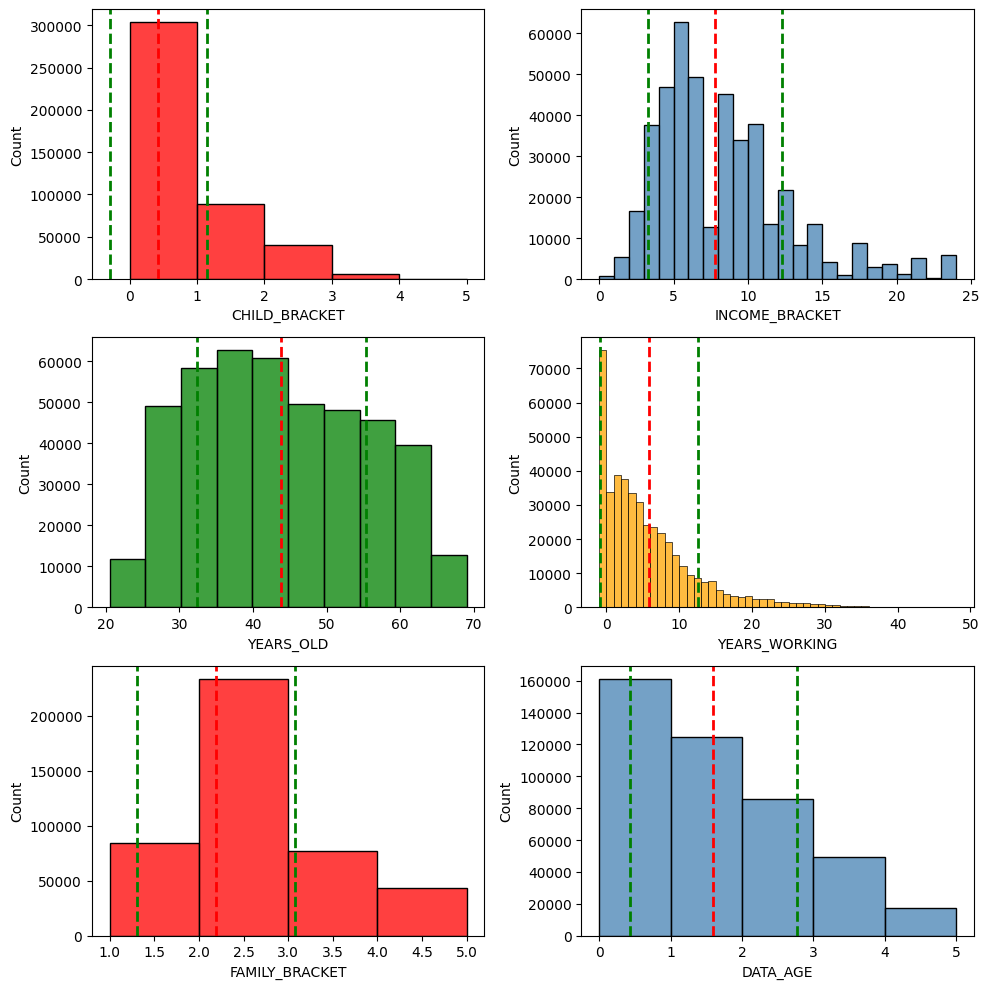

In [14]:
col_list = [('CHILD_BRACKET',1,'red'),\
            ('INCOME_BRACKET',1,'steelblue'),\
            ('YEARS_OLD',5,'green'),\
            ('YEARS_WORKING',1,'orange'),\
            ('FAMILY_BRACKET',1,'red'),
            ('DATA_AGE',1,'steelblue')]
plot_features(applications,col_list,10,10)

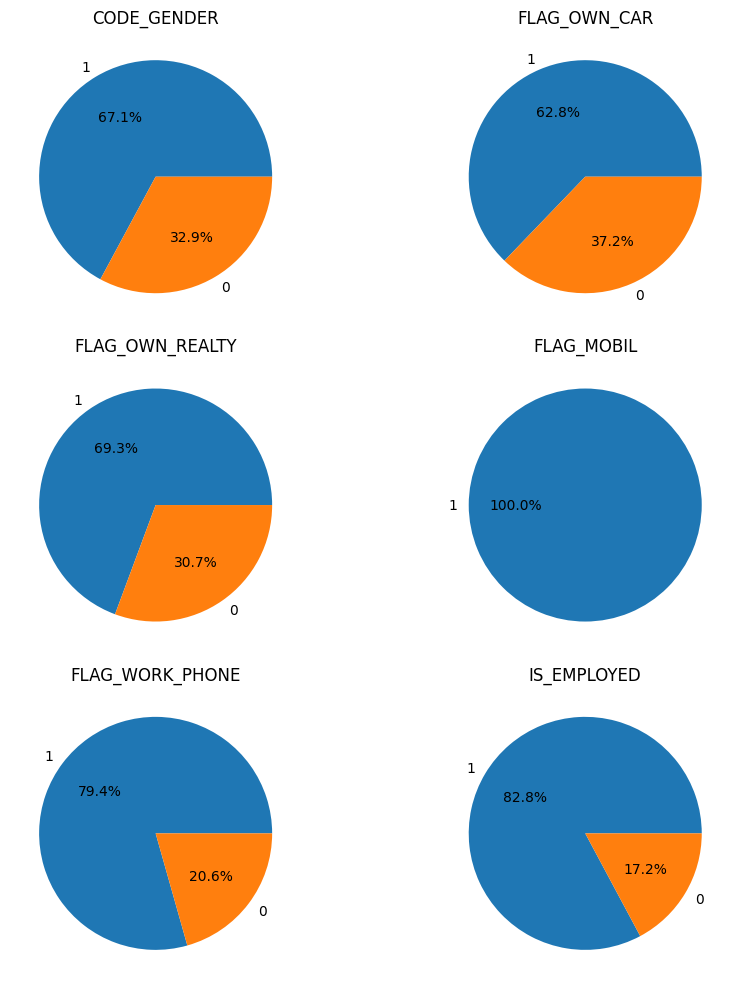

In [15]:
col_list = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_MOBIL','FLAG_WORK_PHONE','IS_EMPLOYED']
plot_pie_charts(applications,col_list,10,10)

# Clusterovanje

In [16]:
tsne = TSNE(n_jobs=-1, verbose = 3)
tsne_res = tsne.fit_transform(applications)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 438557 samples in 0.082s...
[t-SNE] Computed neighbors for 438557 samples in 305.951s...
[t-SNE] Computed conditional probabilities for sample 1000 / 438557
[t-SNE] Computed conditional probabilities for sample 2000 / 438557
[t-SNE] Computed conditional probabilities for sample 3000 / 438557
[t-SNE] Computed conditional probabilities for sample 4000 / 438557
[t-SNE] Computed conditional probabilities for sample 5000 / 438557
[t-SNE] Computed conditional probabilities for sample 6000 / 438557
[t-SNE] Computed conditional probabilities for sample 7000 / 438557
[t-SNE] Computed conditional probabilities for sample 8000 / 438557
[t-SNE] Computed conditional probabilities for sample 9000 / 438557
[t-SNE] Computed conditional probabilities for sample 10000 / 438557
[t-SNE] Computed conditional probabilities for sample 11000 / 438557
[t-SNE] Computed conditional probabilities for sample 12000 / 438557
[t-SNE] Computed conditional proba

KeyboardInterrupt: 

In [ ]:
cred_enc

In [17]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=cred_enc['STATUS'],
    palette=sns.color_palette("hls", 10),
    data=tsne_res,
    legend="full",
    alpha=0.3
)

NameError: name 'tsne_res' is not defined

<Figure size 1600x1000 with 0 Axes>